# Quantitative Exercise

The goal of this notebook is to practice quantitative data analysis using Numenta Anomaly Benchmark (NAB) dataset on Streaming Outlier Detection algorithm, in particular on SPOT (add reference). We will use three different datasets comprising of data retrieved from real world. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

## Load Data

We load the data directly from the csv files in pandas DataFrames, we check if there are some missing values and finally print a sample of the data

In [2]:
df = pd.read_csv('./data/ec2_sys_failure.csv')

In [3]:
print("Missing values: ", df.isnull().values.any())

Missing values:  False


In [4]:
df.head()

,timestamp,value
0,2014-03-07 03:41:00,45.868
1,2014-03-07 03:46:00,47.606
2,2014-03-07 03:51:00,42.580
3,2014-03-07 03:56:00,46.030
4,2014-03-07 04:01:00,44.992


## Exploratory Data Analysis

In this section we will explore the data in more detail. Firstly, we will plot data with different view to understand our dataset. Secondly, we will run our dataset over the SPOT algorithm to find outliers and derive more insights

A time series is a sequence of data samples taken in time order with equal time intervals. Time series include many kinds of real experimental data taken from various domains such as finance, medicine and others.

Given a time series dataset, data exploration and processing are required to analyze them.

### Descriptive Plotting

Basics dataset statistics

In [5]:
df.describe()

,value
count,4032.000000
mean,45.155874
std,2.287089
min,22.864000
25%,43.944000
50%,45.017000
75%,46.362000
max,99.248000


The dataset contains temperature data for a time period of 2 weeks

In [6]:
print(df['timestamp'].min())
print(df['timestamp'].max())

2014-03-07 03:41:00
2014-03-21 03:41:00


Convert data in the right format, DateTime type and values in Celsius

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

The plot below shows that the average cpu usage over time in this days. It is stable around 40-50 with a peak on the 19-03.

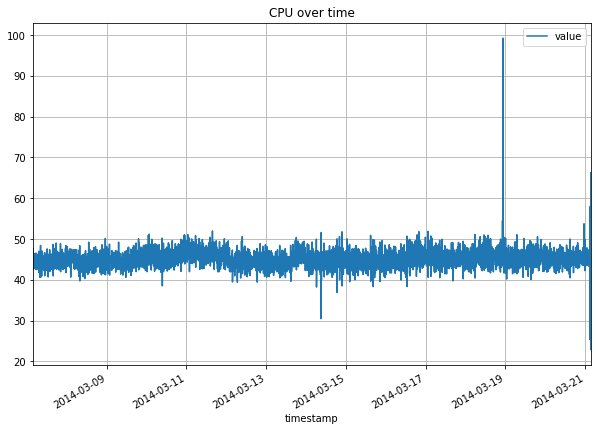

In [8]:
df.plot(x='timestamp', y='value', figsize=(10,7), title='CPU over time', grid=True)

Each data sample in a time series must be associated with a unique point in time. This can be achieved by using values of DatetimeIndex type as its index values

In [9]:
df = df.set_index('timestamp')
df.index
df.sort_index(inplace=True)

A time series can be decomposed into components for further analysis, in this case we decide to model it as an additive of base level, trend, seasonality and error.

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive = seasonal_decompose(df, model='additive', freq=1)
additive_df = pd.concat([additive.seasonal, additive.trend, additive.resid, additive.observed], axis=1)
additive_df.columns = ['seasonal', 'trend', 'resid', 'actual_values']
additive_df.head()

,seasonal,trend,resid,actual_values
timestamp,,,,
2014-03-07 03:41:00,0.0,45.868,0.0,45.868
2014-03-07 03:46:00,0.0,47.606,0.0,47.606
2014-03-07 03:51:00,0.0,42.580,0.0,42.580
2014-03-07 03:56:00,0.0,46.030,0.0,46.030
2014-03-07 04:01:00,0.0,44.992,0.0,44.992


Text(0.5, 0.98, 'Additive Decompose')

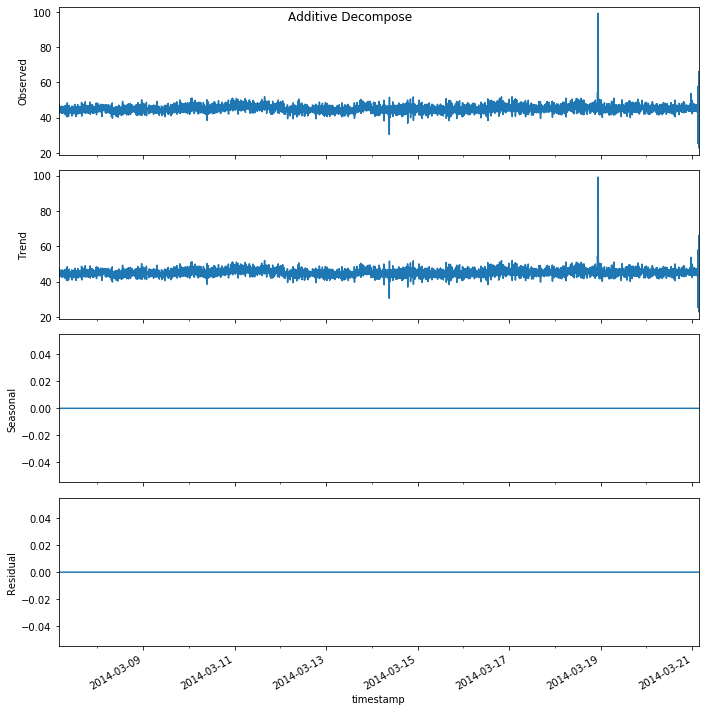

In [11]:
plt.rcParams.update({'figure.figsize': (10,10)})
additive.plot().suptitle('Additive Decompose')

In [12]:
df.reset_index(inplace=True)
df.head()

,timestamp,value
0,2014-03-07 03:41:00,45.868
1,2014-03-07 03:46:00,47.606
2,2014-03-07 03:51:00,42.580
3,2014-03-07 03:56:00,46.030
4,2014-03-07 04:01:00,44.992


In [13]:
df['year'] = df['timestamp'].apply(lambda x : x.year)
df['month'] = df['timestamp'].apply(lambda x : x.month)
df['day'] = df['timestamp'].apply(lambda x : x.day)
df['hour'] = df['timestamp'].apply(lambda x : x.hour)
df['minute'] = df['timestamp'].apply(lambda x : x.minute)

df.index = df['timestamp']
df.drop(['timestamp'], axis=1, inplace=True)
df.head(3)

,value,year,month,day,hour,minute
timestamp,,,,,,
2014-03-07 03:41:00,45.868,2014,3,7,3,41
2014-03-07 03:46:00,47.606,2014,3,7,3,46
2014-03-07 03:51:00,42.580,2014,3,7,3,51


Here, we decided to resample our time series. This means changing the frequency of time series observation. We resampled them by day, week.

In [14]:
weekly = df['value'].resample('W').mean()
daily = df['value'].resample('D').mean()

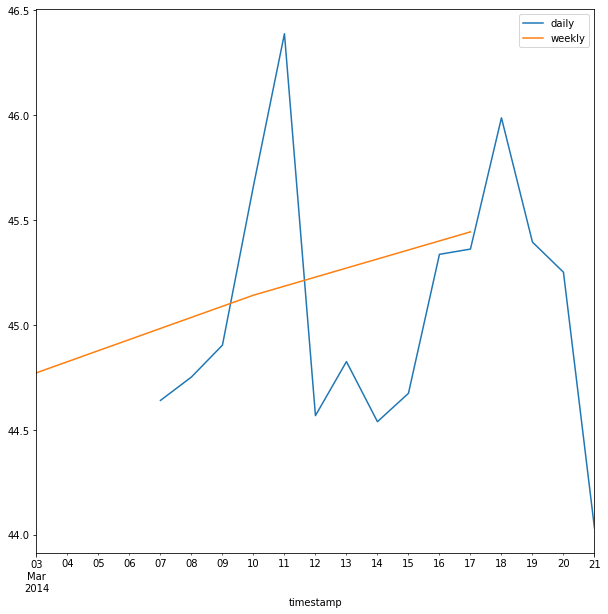

In [15]:
daily.plot()
weekly.plot()
plt.legend(["daily", "weekly", "monthly"])

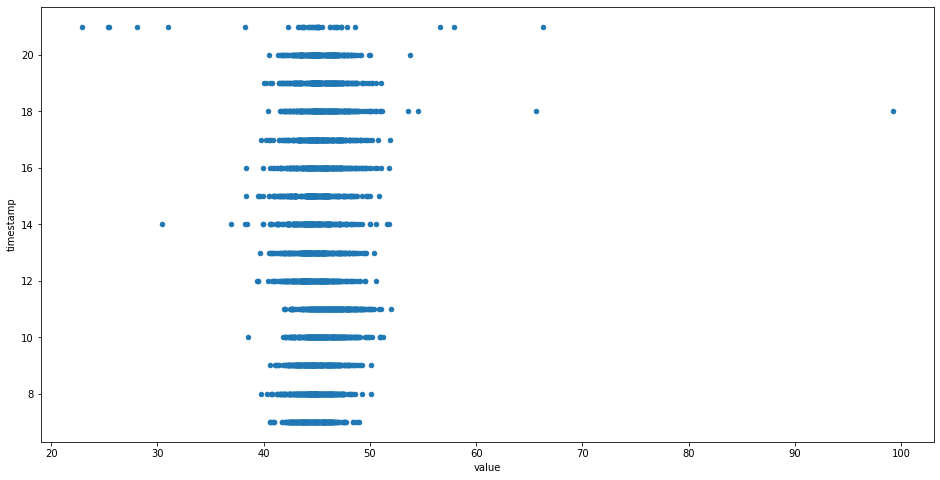

In [16]:
df_2 = pd.read_csv('./data/ec2_sys_failure.csv')
mon = df_2['timestamp']
temp = pd.DatetimeIndex(mon)
days = pd.Series(temp.day)
to_plot = df_2.drop(['timestamp'], axis=1)
to_plot = to_plot.join(days)

to_plot.plot.scatter(x='value',y='timestamp', figsize=(16,8))
plt.show()

# Outlier detection with SPOT

The next step of this quantitative exercise is the research and the study of the outliers. We decided to find the outliers through SPOT algorithm, so after having imported the common libraries, we imported the spot class. In our dataset the indipendent variable is the timestamp in which the aws system failures want to be detected. The value of the performance of aws is our dependent variable because it changes over time. Other two dependent variables are the lower and the upper thresholds. They depend not only on the time, but also on the previous values of the performances of the system. Our expectation in this part of the analysis is to find some outliers that are caused by sudden increments or decrements of the performances.

In [17]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib as mpl
import tqdm as tqdm
import matplotlib.pyplot as plt
from model import spot

After having loaded the original dataset, we splitted the timestamp column in date and time in order to have the possibility of creating intervals based on the date. Due to the fact that the 14st March 2014 is in the middle of the dataset, we decided to split the data around this date. The data before the 14st March 2014 are used as initial batch, while the data after are used as streaming data.

In [18]:
f = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ec2_request_latency_system_failure.csv'

P = pd.read_csv(f)

P[['date', 'time']] = P['timestamp'].str.split(' ', 1, expand=True)

P['date'] = pd.to_datetime(P['date'])
# stream
u_data = (P['date'] >= '2014-03-14')# & (P['date'] < '2014-05-21')
data = P['value'][u_data].values

# initial batch
u_init_data = (P['date'] < '2014-03-14')
init_data = P['value'][u_init_data].values

We set the parameters, initialize the SPOT algorithm and run it. The results are shown in a temporal graph, in which we can see the lower and the upper thresholds in orange, the time series data in blue and the outliers as red points.

 14%|█▍        | 297/2060 [00:00<00:01, 1212.00it/s]

Initial threshold : {'up': 3.816999999999844, 'down': -3.7194000000001566}
Number of peaks : {'up': 39, 'down': 39}
Grimshaw maximum log-likelihood estimation ... [done]
	          Parameters               Upper               Lower
	------------------------------------------------------------
	                   γ                0.00                0.00
	                   σ                0.70                0.58
	          likelihood               24.94               17.56
	    Extreme quantile                9.11               -8.10
	------------------------------------------------------------


100%|██████████| 2060/2060 [00:01<00:00, 1964.96it/s]


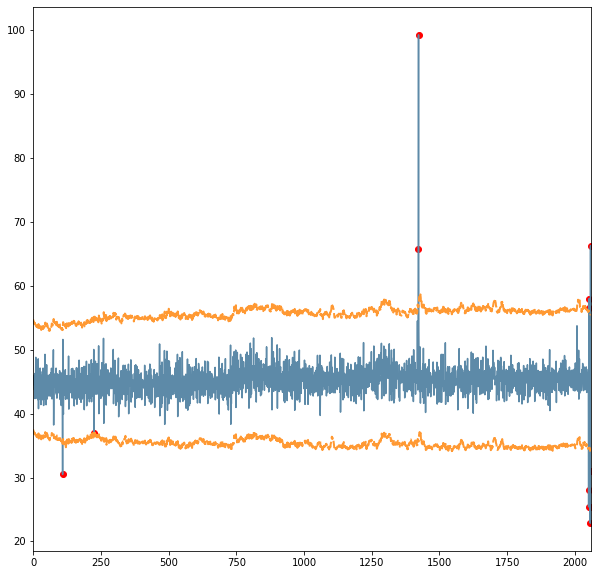

In [19]:
q = 1e-5 			# risk parameter
d = 10				# depth
s = spot.bidSPOT(q,d) 	# bidSPOT object
s.fit(init_data,data) 	# data import
s.initialize() 			# initialization step
results = s.run() 	# run
s.plot(results) 		   # plot

We are intersted only in the data that had been streamed and in particular in the outliers that has been found. So we select only the streamed data and we describe them. We also compute the mean of the thresholds and of the time series.

In [20]:
df = P[u_data]
df.describe()

,value
count,2060.000000
mean,45.194364
std,2.619485
min,22.864000
25%,44.083000
50%,45.046000
75%,46.423000
max,99.248000


In [21]:
from statistics import mean
print("mean of lower threshold : "+ str(mean(results['lower_thresholds'])))
print("mean of aws performance : "+ str(mean(df['value'])))
print("mean of upper threshold : "+ str(mean(results['upper_thresholds'])))

mean of lower threshold : 35.36926155756644
mean of aws performance : 45.1943640776699
mean of upper threshold : 55.65161569348193


After that, we take only the outliers and we visualize and describe them.

In [22]:
out = df.iloc[results['alarms']]
display(out)

,timestamp,value,date,time
2081,2014-03-14 09:06:00,30.482,2014-03-14,09:06:00
2197,2014-03-14 18:46:00,36.890,2014-03-14,18:46:00
3394,2014-03-18 22:36:00,65.680,2014-03-18,22:36:00
3395,2014-03-18 22:41:00,99.248,2014-03-18,22:41:00
4023,2014-03-21 03:01:00,25.422,2014-03-21,03:01:00
4024,2014-03-21 03:06:00,57.958,2014-03-21,03:06:00
4025,2014-03-21 03:11:00,28.052,2014-03-21,03:11:00
4026,2014-03-21 03:16:00,56.572,2014-03-21,03:16:00
4027,2014-03-21 03:21:00,25.352,2014-03-21,03:21:00
4029,2014-03-21 03:31:00,22.864,2014-03-21,03:31:00


In [23]:
out.describe()

,value
count,12.000000
mean,45.478500
std,23.629254
min,22.864000
25%,27.394500
50%,33.926000
75%,59.888500
max,99.248000


We are interested only in outliers, so we create a column in the dataframe that is equal to 1 if the row represents an outlier, 0 otherwise.

In [24]:
df['outlier'] = 0
for a in results['alarms']:
    df['outlier'].iloc[a] = 1
display(df[df['outlier']==1])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_g

,timestamp,value,date,time,outlier
2081,2014-03-14 09:06:00,30.482,2014-03-14,09:06:00,1
2197,2014-03-14 18:46:00,36.890,2014-03-14,18:46:00,1
3394,2014-03-18 22:36:00,65.680,2014-03-18,22:36:00,1
3395,2014-03-18 22:41:00,99.248,2014-03-18,22:41:00,1
4023,2014-03-21 03:01:00,25.422,2014-03-21,03:01:00,1
4024,2014-03-21 03:06:00,57.958,2014-03-21,03:06:00,1
4025,2014-03-21 03:11:00,28.052,2014-03-21,03:11:00,1
4026,2014-03-21 03:16:00,56.572,2014-03-21,03:16:00,1
4027,2014-03-21 03:21:00,25.352,2014-03-21,03:21:00,1
4029,2014-03-21 03:31:00,22.864,2014-03-21,03:31:00,1


In order to better visualize the outliers, we do not show anymore the thresolds so that it is possible to focus our attention on the red points.

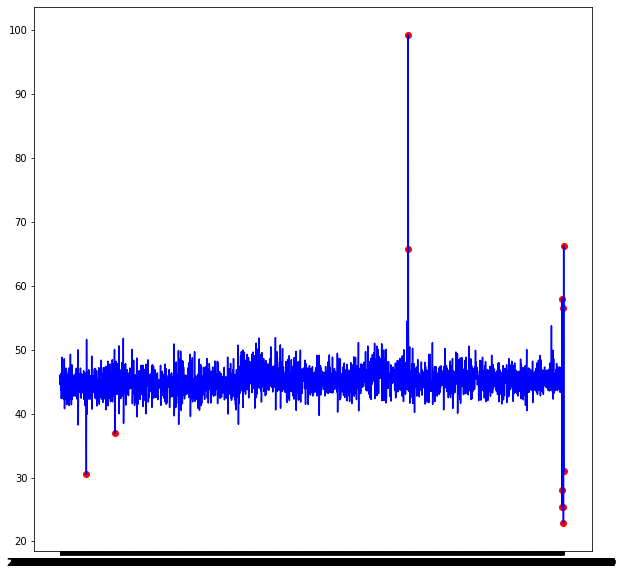

In [25]:
fig, ax = plt.subplots()

a = df.loc[df['outlier'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(df['timestamp'], df['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

As we have seen when we have shown the oulier rows, most of the outliers happened on 21st March 2014, so now a focus on that day is shown. During that day, the performance is increased and decreased rapidly, overcoming both the upper and the lower thresholds, and so they resulted as outliers. Our initial expectation has been satisfied.

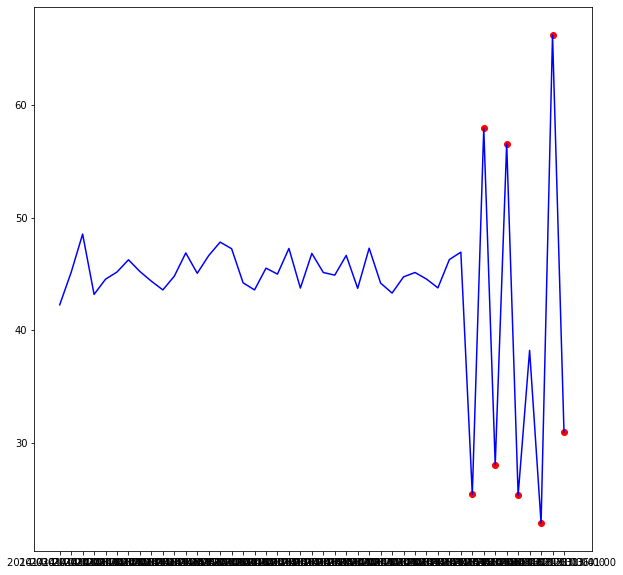

In [26]:
fig, ax = plt.subplots()

df2 = df[(df['date'] == '2014-03-21')]

a = df2.loc[df2['outlier'] == 1, ['timestamp', 'value']] #anomaly

ax.plot(df2['timestamp'], df2['value'], color='blue')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

Finally, we want to visualize the frequence of outliers based on the value of the performances. With this graph it is clear where and when the outliers happen, so when there are system failures.

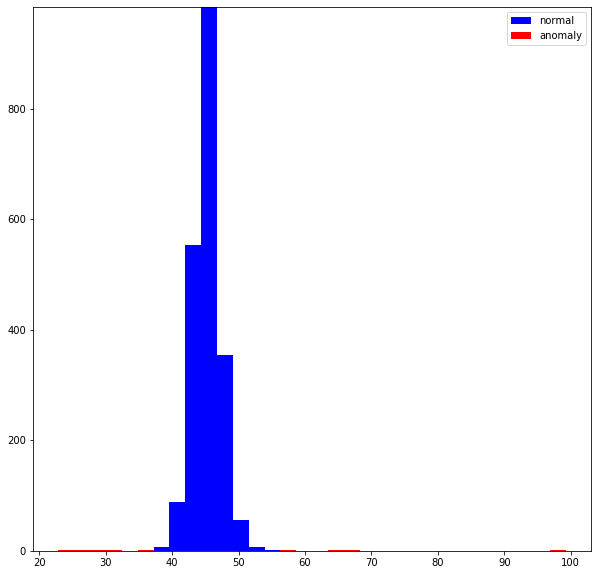

In [27]:
a = df.loc[df['outlier'] == 0, 'value']
b = df.loc[df['outlier'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()